# Drive mount

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("./drive/MyDrive/git_project/TextClassification/src")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Show data list

In [2]:
os.listdir("../data")

['train.csv',
 'test.csv',
 'sample_submission.csv',
 'test_labels.csv',
 'sample_submission.csv.zip',
 'test.csv.zip',
 'train.csv.zip',
 'test_labels.csv.zip',
 'jigsaw-toxic-comment-classification-challenge.zip']

# Import modules

In [3]:
! pip install transformers

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re

nltk.download("punkt")
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
# from transformers import BertTokenizer, BertForSequenceClassification, BertJapaneseTokenizer
from sklearn.model_selection import train_test_split

from itertools import chain
from collections import Counter
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import gensim.downloader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Read files

In [4]:
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

# Check duplicated id set

In [5]:
# if no duplicated id set..
assert train_data["id"].shape == train_data["id"].unique().shape
assert test_data["id"].shape == test_data["id"].unique().shape

# test id includes train id
assert len((set(train_data["id"]) - set(test_data["id"]))) == train_data["id"].shape[0]

# train id includes test id
assert len((set(test_data["id"]) - set(train_data["id"]))) == test_data["id"].shape[0]

In [6]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
all_labels = train_data.iloc[0,2:].index.to_list()
all_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [9]:
train_data.iloc[:,2:].sum(axis=0).sort_values(ascending=False)

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

# Word length frequency

<Axes: ylabel='Frequency'>

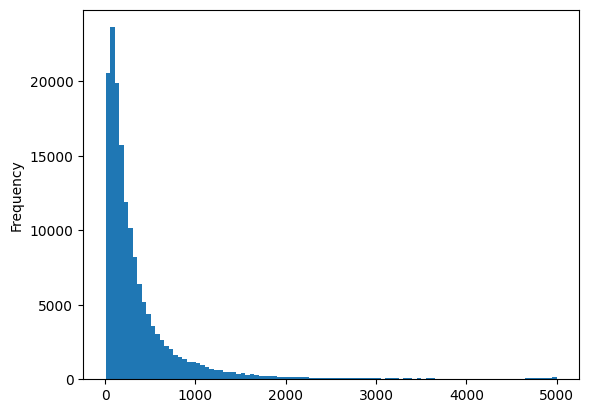

In [10]:
train_data["comment_text"].str.len().plot(kind="hist", bins=100)

In [11]:
train_data["comment_text"].str.len().describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

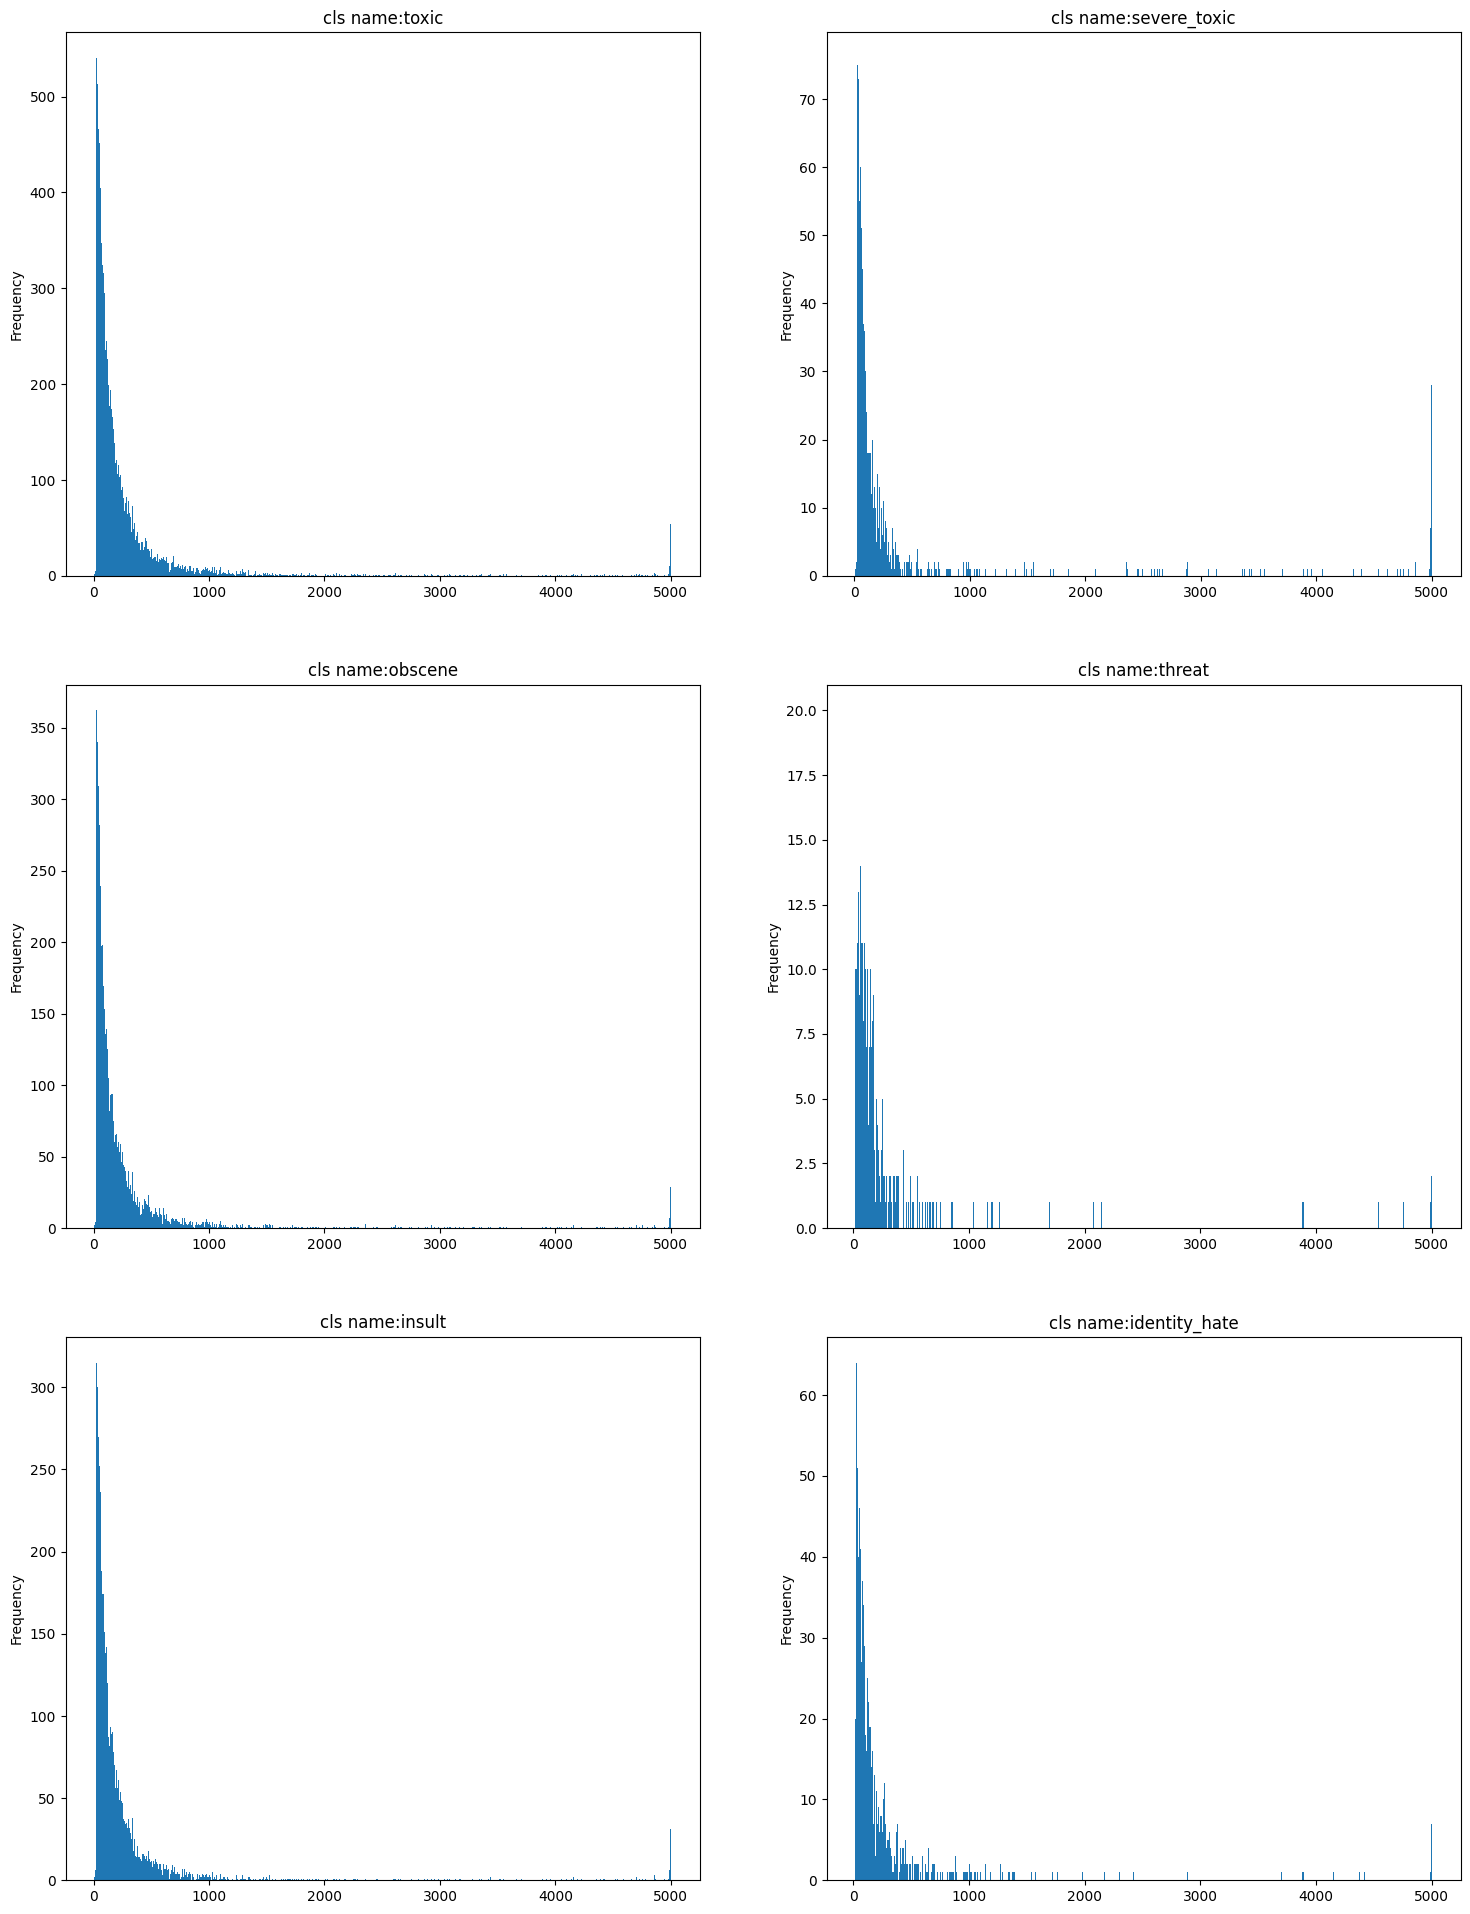

In [12]:
import matplotlib.pyplot as plt
import numpy as np
all_fig_num = len(all_labels)
col_num = int(np.ceil(all_fig_num / 2))
row_num = 2
fig = plt.figure(figsize=(18, 8*col_num))

for index, cls in enumerate(all_labels):
    ax = fig.add_subplot(col_num, row_num, index+1)
    ax.set_title(f"cls name:{cls}")
    train_data.loc[train_data[cls] == 1, "comment_text"].str.len().plot(kind="hist", ax=ax, bins=1000)

# Split train /val

In [6]:
train_data, val_data = train_test_split(train_data, random_state=91, test_size=0.1)

# Label indexing

In [9]:
id2label = {idx:label for idx, label in enumerate(all_labels)}
label2id = {label:idx for idx, label in enumerate(all_labels)}
label2id

{'toxic': 0,
 'severe_toxic': 1,
 'obscene': 2,
 'threat': 3,
 'insult': 4,
 'identity_hate': 5}

# BERT Configs

In [5]:
SHUFFLE_BUFFER = 256
BATCH_SIZE = 128
MODEL_PATH = "../model/model_bert_clf.h5"
MAX_INPUT_LENGTH = 128
DO_TRAIN = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model

In [10]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    problem_type="multi_label_classification",
    num_labels = len(all_labels),
    label2id=label2id,
    id2label=id2label,
    output_attentions = False,
    output_hidden_states = False,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
# from transformers import EvalPrediction
# import torch

# # source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
# def multi_label_metrics(predictions, labels, threshold=0.5):
#     # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
#     sigmoid = torch.nn.Sigmoid()
#     probs = sigmoid(torch.Tensor(predictions))
#     # next, use threshold to turn them into integer predictions
#     y_pred = np.zeros(probs.shape)
#     y_pred[np.where(probs >= threshold)] = 1
#     # finally, compute metrics
#     y_true = labels
#     f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
#     roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
#     accuracy = accuracy_score(y_true, y_pred)
#     # return as dictionary
#     metrics = {'f1': f1_micro_average,
#                'roc_auc': roc_auc,
#                'accuracy': accuracy}
#     return metrics

# def compute_metrics(p: EvalPrediction):
#     preds = p.predictions[0] if isinstance(p.predictions,
#             tuple) else p.predictions
#     result = multi_label_metrics(
#         predictions=preds,
#         labels=p.label_ids)
#     return result

# Dataloader

In [11]:
def get_dataloader(df, step):
    input_ids = []
    token_type_ids = []
    attention_masks = []
    for index, text in tqdm(enumerate(df["comment_text"])):
        encoded_text = tokenizer.encode_plus(
                text,
                add_special_tokens = True,
                max_length = MAX_INPUT_LENGTH,
                pad_to_max_length = True,
                return_attention_mask = True,
                return_tensors = 'pt'
            )
        input_ids.append(encoded_text["input_ids"])
        token_type_ids.append(encoded_text["token_type_ids"])
        attention_masks.append(encoded_text["attention_mask"])

    input_ids_tensor = torch.cat(input_ids)
    token_type_ids_tensor = torch.cat(token_type_ids)
    attention_masks_tensor = torch.cat(attention_masks)

    if step == "test":
        dataset = TensorDataset(input_ids_tensor,
                                token_type_ids_tensor,
                                attention_masks_tensor)
    else:
        labels_tensor = torch.tensor(df.iloc[:, 2:].values)
        dataset = TensorDataset(input_ids_tensor,
                                token_type_ids_tensor,
                                attention_masks_tensor,
                                labels_tensor)

    if step == "train":
        sampler = RandomSampler(dataset)
    else:
        sampler = None
    dataloader = DataLoader(
                dataset,
                sampler = sampler,
                batch_size = BATCH_SIZE
    )
    return dataloader

train_dataloader = get_dataloader(train_data, "train")
valid_dataloader = get_dataloader(val_data, "valid")

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
143613it [04:06, 581.90it/s]
15958it [00:27, 586.89it/s]


# Train

In [ ]:
from itertools import chain
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 5e-5,
                              eps = 1e-08
)

if DO_TRAIN:
    model.to(DEVICE)

    losses = []
    valid_accuracies = []
    epochs = 30

    break_point = 0
    patience = 1
    for epoch in range(1, epochs):
        print(f"Epoch:{epoch}")
        torch.cuda.empty_cache()
        epoch_loss = 0
        for step, batch in tqdm(enumerate(train_dataloader)):
            model.train()
            torch.cuda.empty_cache()
            batch = tuple(t.to(DEVICE) for t in batch)
            b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
            optimizer.zero_grad()
            # Forward pass
            train_output = model(
                input_ids = b_input_ids,
                token_type_ids = b_token_type_ids,
                attention_mask = b_input_mask,
                labels = b_labels.to(torch.float)
            )
            # Backward pass
            train_output.loss.backward()
            optimizer.step()
            # Update tracking variables
            step_loss = train_output.loss.item() / BATCH_SIZE
            epoch_loss += step_loss

        torch.cuda.empty_cache()
        print("validation -->..")
        with torch.no_grad():
            model.eval()
            preds = []
            labels = []
            for batch in tqdm(valid_dataloader):
                torch.cuda.empty_cache()
                batch = tuple(t.to(DEVICE) for t in batch)
                b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
                # Forward pass
                pred = model(
                    input_ids = b_input_ids,
                    token_type_ids = b_token_type_ids,
                    attention_mask = b_input_mask,
                    labels = b_labels.to(torch.float)
                )
                preds.append((torch.sigmoid(pred["logits"])>0.5).detach().cpu().numpy()*1)
                labels.append(b_labels.detach().cpu().numpy())

        p = np.array(list(chain(*preds)))
        l = np.array(list(chain(*labels)))
        acc = ((p == l).sum(axis=1) == 6).mean()


        epoch_loss = epoch_loss / step
        print(f"Epoch:{epoch}, loss:{epoch_loss}, valid_accuracy:{acc}")
        losses.append(epoch_loss)
        valid_accuracies.append(acc)

        if max(valid_accuracies) > acc:
            break_point += 1
            if break_point >= patience:
                break
        else:
            # save model
            model.save_pretrained(MODEL_PATH)


Epoch:1


1122it [50:22,  2.69s/it]


validation -->..


100%|██████████| 125/125 [02:02<00:00,  1.02it/s]


Epoch:1, loss:0.00043340179542613146, valid_accuracy:0.9266198771775912
Epoch:2


1122it [50:30,  2.70s/it]


validation -->..


100%|██████████| 125/125 [02:02<00:00,  1.02it/s]


Epoch:2, loss:0.0002685099405930361, valid_accuracy:0.9274971800977566
Epoch:3


712it [32:03,  2.70s/it]

# Inference

In [13]:
print("test -->..")
test_dataloader = get_dataloader(test_data, "test")
infer_model = BertForSequenceClassification.from_pretrained(
    MODEL_PATH,
    output_attentions = False,
    output_hidden_states = False,
)

with torch.no_grad():
    infer_model.eval()
    infer_model.to(DEVICE)
    preds = []
    labels = []
    for batch in tqdm(test_dataloader):
        torch.cuda.empty_cache()
        batch = tuple(t.to(DEVICE) for t in batch)
        b_input_ids, b_token_type_ids, b_input_mask = batch
        # Forward pass
        pred = infer_model(
            input_ids = b_input_ids,
            token_type_ids = b_token_type_ids,
            attention_mask = b_input_mask,
        )
        preds.append((torch.sigmoid(pred["logits"])>0.5).detach().cpu().numpy()*1)

p = np.array(list(chain(*preds)))

test -->..


100%|██████████| 1197/1197 [19:27<00:00,  1.03it/s]


# Kaggle submission

In [40]:
submission = pd.concat([test_data, pd.DataFrame(p, columns=all_labels)], axis=1)
submission = submission.drop(["comment_text"], axis=1)
os.makedirs("../result", exist_ok=True)
submission.to_csv("../result/submission.csv", index=False)
pd.read_csv("../result/submission.csv").head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1,1,1,0,1,1
1,0000247867823ef7,0,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0


In [41]:
import os
import json
f = open("../../kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f ../result/submission.csv -m "Message"

100% 4.24M/4.24M [00:00<00:00, 15.1MB/s]
Successfully submitted to Toxic Comment Classification Challenge